# Cleaning

**We have cleaned the following in the given dataset membership.csv :**
- Invalid dates
- Dropping duplicates
- Null or missing values
- Check for 0 or negative price values
- Remove dates in the future

**We have done the following for improved readability :**
- Rename Clients
- Rename ContactIds

**Insights**
- A person (ContactId) can be a member of two different products at the same time.

In [409]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression
from matplotlib.dates import date2num
from datetime import datetime
from scipy.stats import ttest_ind

In [410]:
# ImpexiumInsights is the membership data
df = pd.read_csv('membership.csv')

# Change clients to a more readable format as the following:
# Client_1 -> ICSC
# Client_2 -> SIOR
# Client_3 -> NAIOP
df['Client'] = df['Client'].replace('Client_1', 'ICSC')
df['Client'] = df['Client'].replace('Client_2', 'SIOR')
df['Client'] = df['Client'].replace('Client_3', 'NAIOP')
df.head(10)

,ContactId,ClientId,Client,ProductId,ProductType,EffectiveDate,ExpireDate,Total
0,0x566B63D73878FD95925F7B6716FAB095,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,9/1/21,8/31/22,104.49
1,0x77D707DC7112E8379C27E3A1AF0EC034,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,8/1/21,7/31/22,104.49
2,0xC36639462513FE7C2413AF7449B281BD,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0xCF82E756F655A4E1518567DCDB80CCBF,Membership,6/27/21,6/26/22,36.45
3,0xC36639462513FE7C2413AF7449B281BD,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,6/19/21,6/18/22,104.49
4,0xBDF36B8927A18BC973A2AE91E7F5112F,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,6/27/21,6/26/22,104.49
5,0x18CC10100F771A69BFD13098384C7E46,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,8/2/21,8/1/22,104.49
6,0x0E49629AB8D42E50157CFDE15186FD8B,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,6/29/21,6/28/22,104.49
7,0xB584C9347DE96FFE23C5BD103626F03F,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,6/28/21,6/27/22,104.49
8,0x7181625DB00B71EAA5FEB7C1632F92EB,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,6/28/21,6/27/22,104.49
9,0xD35391A8B2400414D05B610DBC052102,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,1/1/20,12/31/20,104.49


In [411]:
# How many rows do start with?
df.count()

ContactId        250064
ClientId         250064
Client           250064
ProductId        250064
ProductType      250064
EffectiveDate    250064
ExpireDate       250064
Total            250064
dtype: int64

In [412]:
# Removing all entries where EffectiveDate > ExpireDate
df['EffectiveDate'] = pd.to_datetime(df['EffectiveDate'], format='%m/%d/%y')
df['ExpireDate'] = pd.to_datetime(df['ExpireDate'], format='%m/%d/%y')
valid_df = df[df['EffectiveDate'] <= df['ExpireDate']]

# Check 
invalid_df = valid_df[valid_df['EffectiveDate'] > valid_df['ExpireDate']]
print("Are there any entries in the new data frame that are invalid for dates?", not(invalid_df.to_xarray))


# Check passed so modify data frame
df = valid_df

Are there any entries in the new data frame that are invalid for dates? False


In [413]:
# Are there any prices that are 0 or negative?
invalid_rows = df[df['Total'] <= 0]

# Check
print("Are there any prices that are 0 or negative?", not(invalid_rows.to_xarray))

Are there any prices that are 0 or negative? False


In [414]:
# Can different people be members of the same ProductId at the same time?
unique_products = df.groupby('ContactId')['ProductId'].nunique()
subscriptions = unique_products[unique_products > 1]

# Check
print("Can different people be members of the same ProductId at the same time?", not(not({subscriptions.to_dict})))

Can different people be members of the same ProductId at the same time? True


In [415]:
# Before we check duplicates, check for this question:
# Can entries that have the same ContactId, ProductId, EffectiveDate, ExpireDate, have different Total values.

# Group entries by chosed columns to check for variability in Total
total_cols = df.groupby(['ContactId', 'ProductId', 'EffectiveDate', 'ExpireDate'])['Total'].nunique() > 1

# Create a new dataframe based on more than 1 Total values
indexes = total_cols[total_cols].index
unique_totals = df.set_index(['ContactId', 'ProductId', 'EffectiveDate', 'ExpireDate'])
updated_df = unique_totals.loc[indexes].reset_index()

# Check
print("Entries:")
print(updated_df)

Entries:
                              ContactId                           ProductId  \
0    0x008788A10C4D48BE2BA6B88FB1DF883C  0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44   
1    0x008788A10C4D48BE2BA6B88FB1DF883C  0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44   
2    0x008B06399E57D57AC7BDF126F9F0A3FE  0x9E8B160226C9FE22A910C782CE5076E2   
3    0x008B06399E57D57AC7BDF126F9F0A3FE  0x9E8B160226C9FE22A910C782CE5076E2   
4    0x08B59C5D8D0B6A939D86AB1DF5A50375  0x9E8B160226C9FE22A910C782CE5076E2   
..                                  ...                                 ...   
316  0xFECB0580DFD2886ECF6058CF92CAAFD5  0x9E8B160226C9FE22A910C782CE5076E2   
317  0xFECB0580DFD2886ECF6058CF92CAAFD5  0x9E8B160226C9FE22A910C782CE5076E2   
318  0xFEE01732A992D1A6ADFB98EB59ADA1A3  0x9E8B160226C9FE22A910C782CE5076E2   
319  0xFEE01732A992D1A6ADFB98EB59ADA1A3  0x9E8B160226C9FE22A910C782CE5076E2   
320  0xFEE01732A992D1A6ADFB98EB59ADA1A3  0x9E8B160226C9FE22A910C782CE5076E2   

    EffectiveDate ExpireDate              

In [416]:
# Dropping all duplicates that have the same ContactId, ProductId, EffectiveDate, and ExpireDate
df['EffectiveDate'] = pd.to_datetime(df['EffectiveDate'], format='%m/%d/%y')
df['ExpireDate'] = pd.to_datetime(df['ExpireDate'], format='%m/%d/%y')
df_unique = df.drop_duplicates(subset=['ContactId', 'ProductId', 'EffectiveDate', 'ExpireDate'])

# Check 
duplicates_check = df_unique.duplicated(subset=['ContactId', 'ProductId', 'EffectiveDate', 'ExpireDate'], keep=False)
no_duplicates = not duplicates_check.any()
print("There are no duplicates in the new data frame, based on the specified columns above?", no_duplicates)

# Check passed so modify data frame
df = df_unique

There are no duplicates in the new data frame, based on the specified columns above? True


In [417]:
# Identifying any null or missing values
missing_entries = df[df.isnull().any(axis=1) | df.applymap(lambda x: x == '').any(axis=1)]

# Check
print("Are there any null or missing values in the data frame?", not(missing_entries.to_xarray))

Are there any null or missing values in the data frame? False


In [418]:
# Cleaning: removing all dates in the future.

# Cutoff date is May 2024
cutoff_date = pd.Timestamp('2024-05-01')
df_filtered = df[(df['EffectiveDate'] < cutoff_date) & (df['ExpireDate'] < cutoff_date)]
eff_check = df_filtered['EffectiveDate'].max()
exp_check = df_filtered['ExpireDate'].max()
print("Checks:")
print(eff_check < cutoff_date)
print(exp_check < cutoff_date)

# Check passed so modify data frame
df = df_filtered

Checks:
True
True


In [419]:
# Generate a unique "Member X" identifier for each unique ContactId
temp_df = df.copy()
unique_ids = temp_df['ContactId'].unique()
member_mapping = {id_: f"Member {i+1}" for i, id_ in enumerate(unique_ids)}
temp_df['ContactId'] = temp_df['ContactId'].map(member_mapping)

# Check
print(temp_df.head(5))

# Check passed so modify data frame
df = temp_df

  ContactId                            ClientId Client  \
0  Member 1  0xCAB892266CB7872B20CED441410BFF5E   SIOR   
1  Member 2  0xCAB892266CB7872B20CED441410BFF5E   SIOR   
2  Member 3  0xCAB892266CB7872B20CED441410BFF5E   SIOR   
3  Member 3  0xCAB892266CB7872B20CED441410BFF5E   SIOR   
4  Member 4  0xCAB892266CB7872B20CED441410BFF5E   SIOR   

                            ProductId ProductType EffectiveDate ExpireDate  \
0  0x9E8B160226C9FE22A910C782CE5076E2  Membership    2021-09-01 2022-08-31   
1  0x9E8B160226C9FE22A910C782CE5076E2  Membership    2021-08-01 2022-07-31   
2  0xCF82E756F655A4E1518567DCDB80CCBF  Membership    2021-06-27 2022-06-26   
3  0x9E8B160226C9FE22A910C782CE5076E2  Membership    2021-06-19 2022-06-18   
4  0x9E8B160226C9FE22A910C782CE5076E2  Membership    2021-06-27 2022-06-26   

    Total  
0  104.49  
1  104.49  
2   36.45  
3  104.49  
4  104.49  


In [420]:
# How many rows do we clean to?
df.count()

ContactId        239521
ClientId         239521
Client           239521
ProductId        239521
ProductType      239521
EffectiveDate    239521
ExpireDate       239521
Total            239521
dtype: int64

In [421]:
# Saving updated data frame to the csv
# Always run this at the end of your work session:
df.to_csv('modified_membership.csv', index=False)

In [422]:
# Deep copy
df_mem = df.copy(deep=True)
df_mem.head()

,ContactId,ClientId,Client,ProductId,ProductType,EffectiveDate,ExpireDate,Total
0,Member 1,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,2021-09-01,2022-08-31,104.49
1,Member 2,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,2021-08-01,2022-07-31,104.49
2,Member 3,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0xCF82E756F655A4E1518567DCDB80CCBF,Membership,2021-06-27,2022-06-26,36.45
3,Member 3,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,2021-06-19,2022-06-18,104.49
4,Member 4,0xCAB892266CB7872B20CED441410BFF5E,SIOR,0x9E8B160226C9FE22A910C782CE5076E2,Membership,2021-06-27,2022-06-26,104.49


# Analysis

**Questions we looked into :**

In [423]:
# Proportion of people that renew memberships?

# Sort the DataFrame and avoid changing the original df
df_s = df.sort_values(by=['ContactId', 'ProductId', 'EffectiveDate', 'ExpireDate'])
df_s['EffectiveDate'] = pd.to_datetime(df_s['EffectiveDate'], format='%m/%d/%Y')
df_s['ExpireDate'] = pd.to_datetime(df_s['ExpireDate'], format='%m/%d/%Y')

# Custom function to identify renewals
def check_membership(group):
    group['Renewed'] = group['EffectiveDate'].shift(-1) > group['ExpireDate']
    return group

renewals = df_s.groupby(['ContactId', 'ProductId'], group_keys=False).apply(check_membership)
df_renewed_memberships = renewals[renewals['Renewed'] == True]
renewed_unique_contact_ids = df_renewed_memberships['ContactId'].nunique()
total_unique_contact_ids = df['ContactId'].nunique()

# Check
print("Proportion of active members: ", renewed_unique_contact_ids, "out of", total_unique_contact_ids)

Proportion of active members:  39353 out of 92829


In [424]:
# Proportion of people that renew membership based on Clients.

# Custom function to identify renewals
def calculate_renewal_rate(client_df):
    # Sort the DataFrame and avoid changing the original df
    df_s = client_df.sort_values(by=['ContactId', 'ProductId', 'EffectiveDate', 'ExpireDate'])
    df_s['EffectiveDate'] = pd.to_datetime(df_s['EffectiveDate'], format='%m/%d/%Y')
    df_s['ExpireDate'] = pd.to_datetime(df_s['ExpireDate'], format='%m/%d/%Y')
    
    # The actual checking logic
    renewals = df_s.groupby(['ContactId', 'ProductId'], group_keys=False).apply(check_membership)
    df_renewed_memberships = renewals[renewals['Renewed'] == True]
    renewed_unique_contact_ids = df_renewed_memberships['ContactId'].nunique()
    total_unique_contact_ids = client_df['ContactId'].nunique()
    
    # Defining ans
    # ans = "Proportion of active members: ", renewed_unique_contact_ids, "out of", total_unique_contact_ids
    return renewed_unique_contact_ids / total_unique_contact_ids if total_unique_contact_ids else 0

# Apply the custom function to each client
clients = ['ICSC', 'SIOR', 'NAIOP']

# Storing renewal rates in the dictionary
renewal_rates = {}
for client in clients:
    client_df = df[df['Client'] == client]
    renewal_rates[client] = calculate_renewal_rate(client_df)
    
print(renewal_rates)
print("Client 2, SIOR, has the highet renewals with approximately 48%")

{'ICSC': 0.18937415578568212, 'SIOR': 0.48200942292110555, 'NAIOP': 0.33996551266746255}
Client 2, SIOR, has the highet renewals with approximately 48%


In [425]:
# The most revenue generating Client

client_totals = df.groupby('Client')['Total'].sum()
print(client_totals)
print("The most highest revenue generating client is Client 2, SIOR, with a total of $11,282,100")

Client
ICSC     1.755890e+06
NAIOP    4.434940e+06
SIOR     1.128186e+07
Name: Total, dtype: float64
The most highest revenue generating client is Client 2, SIOR, with a total of $11,282,100


In [426]:
# Checking if a ProductId can belong to mutliple clients?

product_by_clients = df.groupby('ProductId')['Client'].unique()
overlap = product_by_clients[product_by_clients.apply(len) > 1]
print("Products associated with more than one client:")
print(overlap)

Products associated with more than one client:
ProductId
0x9E8B160226C9FE22A910C782CE5076E2    [SIOR, ICSC]
0xF5C0A1C9384C2E25E79BA1ABF5D9A037    [SIOR, ICSC]
Name: Client, dtype: object


In [427]:
# Find the proportion of products that have multiple 'Total' values to all products.

products_by_totals = df.groupby('ProductId')['Total'].nunique()
num_products = (products_by_totals > 1).sum()
total_products = df['ProductId'].nunique()
proportion = num_products / total_products
print("The proportion of products with multiple total values:", (num_products / total_products))

The proportion of products with multiple total values: 0.5396825396825397


In [428]:
# Finding the most profitable products? And compare the result to top products by entries.
# If the top 10 most profitable products has multiple clients, then those clients are listed.

product_by_totals = df.groupby('ProductId')['Total'].sum()
product_by_clients = df.groupby('ProductId')['Client'].unique().apply(', '.join)
product_by_count = df.groupby('ProductId').size()

# Combining products for clients
combined_df = pd.DataFrame({
    'TotalValue': product_by_totals,
    'Clients': product_by_clients,
    'EntriesCount': product_by_count
})
sorted_df = combined_df.sort_values(by='TotalValue', ascending=False)
most_revenue = sorted_df.head(10)
print("Top 10 products by total value along with their associated clients:")
print(most_revenue)

# Compare results
entries_df = pd.DataFrame({
    'EntriesCount': product_by_count
}).sort_values(by='EntriesCount', ascending=False)
most_entries = entries_df.head(5)
print("\n")
print("Top 5 products by number of entries:")
print(most_entries)

Top 10 products by total value along with their associated clients:
                                      TotalValue     Clients  EntriesCount
ProductId                                                                 
0x9E8B160226C9FE22A910C782CE5076E2  7.833360e+06  SIOR, ICSC         71388
0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44  2.797043e+06       NAIOP         16327
0xF5C0A1C9384C2E25E79BA1ABF5D9A037  2.062277e+06  SIOR, ICSC         38233
0xB1D787D73861B99E3C6EAAB152ECC267  1.073884e+06       NAIOP          3325
0x83328A9B5BCBD66B31C8B882E78C7B0F  1.046778e+06        SIOR         67665
0xBC0C8546EF1FC064C277B3CEECF1B68E  5.484348e+05        SIOR          9811
0x1F9328EF4BFD437D552C96F5B1D116EE  2.846097e+05       NAIOP          1660
0x8C19A547F4F2D76D4F47B8EFFB73F4F7  1.972465e+05        ICSC          1449
0x54F95A5E234DD10A3244A98632BA45CB  1.760362e+05        ICSC          1866
0x5158A250E30F1FB4415D86DED2C8E0C5  1.528739e+05        ICSC           499


Top 5 products by number of en

In [429]:
# Getting the minimum, maximum, median, mean, and standard deviation for the top 5 products.

# Use the previous most_revenue output to filter and find statistics
filter_df = most_revenue.index[:5]
product_stats = df[df['ProductId'].isin(filter_df)]
stats_df = product_stats.groupby('ProductId')['Total'].agg(['min', 'max', 'median', 'mean', 'std'])

# Display data in descending order for Total value
ordered_df = stats_df.reindex(filter_df)
print("Statistics for top 5 products by Total:")
print(ordered_df)

# Finding the statistics for the Total column as a whole
general_stats = df['Total'].agg(['min', 'max', 'median', 'mean', 'std'])

# Displaying results
print("\n")
print("Statistics for the Total column:")
print(general_stats)

Statistics for top 5 products by Total:
                                         min       max    median        mean  \
ProductId                                                                      
0x9E8B160226C9FE22A910C782CE5076E2    0.8100   253.125  104.4900  109.729365   
0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44    9.7200   230.850  170.1000  171.313958   
0xF5C0A1C9384C2E25E79BA1ABF5D9A037   13.5027    77.760   55.8900   53.939715   
0xB1D787D73861B99E3C6EAAB152ECC267  275.4000  1069.200  319.9500  322.972701   
0x83328A9B5BCBD66B31C8B882E78C7B0F    1.4580   125.874   10.4895   15.470000   

                                          std  
ProductId                                      
0x9E8B160226C9FE22A910C782CE5076E2  23.139173  
0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44   4.524739  
0xF5C0A1C9384C2E25E79BA1ABF5D9A037   6.819395  
0xB1D787D73861B99E3C6EAAB152ECC267  16.440980  
0x83328A9B5BCBD66B31C8B882E78C7B0F  23.449220  


Statistics for the Total column:
min          0.810000
max   

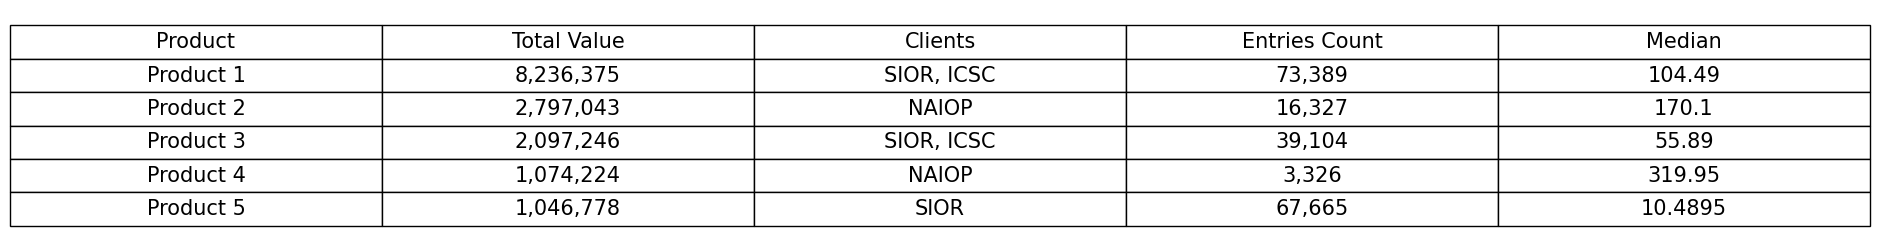

In [430]:
# Manually putting in the data
table_data = [
    ["Product", "Total Value", "Clients", "Entries Count", "Median"],
    ["Product 1", "8,236,375", "SIOR, ICSC", "73,389", "104.49"],
    ["Product 2", "2,797,043", "NAIOP", "16,327", "170.1"],
    ["Product 3", "2,097,246", "SIOR, ICSC", "39,104", "55.89"],
    ["Product 4", "1,074,224", "NAIOP", "3,326", "319.95"],
    ["Product 5", "1,046,778", "SIOR", "67,665", "10.4895"]
]

# Creating the plot and axis
fig, ax = plt.subplots(figsize=(12, 3))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')

# Creating the table
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.2 for x in table_data[0]])
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(2, 2)
plt.show()

In [431]:
# Finding the top performing products per client

products_clients = df.groupby(['Client', 'ProductId'])['Total'].sum().reset_index()
sorted = products_clients.sort_values(['Client', 'Total'], ascending=[True, False])
profits = sorted.groupby('Client').head(10)
print(profits)

   Client                           ProductId         Total
3    ICSC  0x9E8B160226C9FE22A910C782CE5076E2  1.122092e+06
2    ICSC  0x8C19A547F4F2D76D4F47B8EFFB73F4F7  1.972465e+05
1    ICSC  0x54F95A5E234DD10A3244A98632BA45CB  1.760362e+05
0    ICSC  0x5158A250E30F1FB4415D86DED2C8E0C5  1.528739e+05
4    ICSC  0xF5C0A1C9384C2E25E79BA1ABF5D9A037  1.076415e+05
11  NAIOP  0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44  2.797043e+06
13  NAIOP  0xB1D787D73861B99E3C6EAAB152ECC267  1.073884e+06
7   NAIOP  0x1F9328EF4BFD437D552C96F5B1D116EE  2.846097e+05
14  NAIOP  0xB794B776FB974C9B09BDE6A815EFFCD8  9.956115e+04
12  NAIOP  0xA23E0E7B83DB6A0D4B958C46E70CED19  8.465310e+04
8   NAIOP  0x85705D7BF13E936A6B07F7CC0047211F  4.799736e+04
5   NAIOP  0x0BCE80143CB901200D9A331930AA0315  4.367439e+04
10  NAIOP  0x896D76C40828972B7A92CA2BDBA6BE22  3.118500e+03
6   NAIOP  0x10AB8A62F22A93DFA334BE19E73A6832  3.693600e+02
9   NAIOP  0x859F45F9B7C86C38399DA51D19C7A5F6  2.916000e+01
44   SIOR  0x9E8B160226C9FE22A910C782CE5

In [432]:
# How many unique products exist in each client?

unique_products = df.groupby('Client')['ProductId'].nunique()
print("Unique products by client:")
print(unique_products)

Unique products by client:
Client
ICSC      5
NAIOP    10
SIOR     50
Name: ProductId, dtype: int64


In [433]:
# Percentage of sales top products account for.

top_ds = {
    'ICSC': ["0x9E8B160226C9FE22A910C782CE5076E2"],
    'NAIOP': ["0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44"],
    'SIOR': ["0x9E8B160226C9FE22A910C782CE5076E2"]
}
total_sales = df.groupby('Client')['Total'].sum()

# Top 1
for client, product_ids in top_ds.items():
    totals_products = df[df['ProductId'].isin(product_ids) & (df['Client'] == client)]['Total'].sum()
    percent = (totals_products / total_sales[client]) * 100
    print(f"Client {client} - Percentage of sales by top 1 product: {percent:.2f}%")

# Top 2
top_ds['ICSC'].append("0x8C19A547F4F2D76D4F47B8EFFB73F4F7")
top_ds['NAIOP'].append("0xB1D787D73861B99E3C6EAAB152ECC267")
top_ds['SIOR'].append("0xF5C0A1C9384C2E25E79BA1ABF5D9A037")
print("\n")
for client, product_ids in top_ds.items():
    totals_products = df[df['ProductId'].isin(product_ids) & (df['Client'] == client)]['Total'].sum()
    percent = (totals_products / total_sales[client]) * 100
    print(f"Client {client} - Percentage of sales by top 2 producs: {percent:.2f}%")

# Top 3
top_ds['ICSC'].append("0x54F95A5E234DD10A3244A98632BA45CB")
top_ds['NAIOP'].append("0x1F9328EF4BFD437D552C96F5B1D116EE")
top_ds['SIOR'].append("0x83328A9B5BCBD66B31C8B882E78C7B0F")
print("\n")
for client, product_ids in top_ds.items():
    totals_products = df[df['ProductId'].isin(product_ids) & (df['Client'] == client)]['Total'].sum()
    percent = (totals_products / total_sales[client]) * 100
    print(f"Client {client} - Percentage of sales by top 3 producs: {percent:.2f}%")

# Top 4
top_ds['ICSC'].append("0x5158A250E30F1FB4415D86DED2C8E0C5")
top_ds['NAIOP'].append("0xB794B776FB974C9B09BDE6A815EFFCD8")
top_ds['SIOR'].append("0xBC0C8546EF1FC064C277B3CEECF1B68E")
print("\n")
for client, product_ids in top_ds.items():
    totals_products = df[df['ProductId'].isin(product_ids) & (df['Client'] == client)]['Total'].sum()
    percent = (totals_products / total_sales[client]) * 100
    print(f"Client {client} - Percentage of sales by top 4 producs: {percent:.2f}%")

# Top 5
top_ds['ICSC'].append("0xF5C0A1C9384C2E25E79BA1ABF5D9A037")
top_ds['NAIOP'].append("0xA23E0E7B83DB6A0D4B958C46E70CED19")
top_ds['SIOR'].append("0xD109AC74DF282488EFD1DD7621A847D2")
print("\n")
for client, product_ids in top_ds.items():
    totals_products = df[df['ProductId'].isin(product_ids) & (df['Client'] == client)]['Total'].sum()
    percent = (totals_products / total_sales[client]) * 100
    print(f"Client {client} - Percentage of sales by top 5 producs: {percent:.2f}%")

Client ICSC - Percentage of sales by top 1 product: 63.90%
Client NAIOP - Percentage of sales by top 1 product: 63.07%
Client SIOR - Percentage of sales by top 1 product: 59.49%


Client ICSC - Percentage of sales by top 2 producs: 75.14%
Client NAIOP - Percentage of sales by top 2 producs: 87.28%
Client SIOR - Percentage of sales by top 2 producs: 76.81%


Client ICSC - Percentage of sales by top 3 producs: 85.16%
Client NAIOP - Percentage of sales by top 3 producs: 93.70%
Client SIOR - Percentage of sales by top 3 producs: 86.09%


Client ICSC - Percentage of sales by top 4 producs: 93.87%
Client NAIOP - Percentage of sales by top 4 producs: 95.94%
Client SIOR - Percentage of sales by top 4 producs: 90.95%


Client ICSC - Percentage of sales by top 5 producs: 100.00%
Client NAIOP - Percentage of sales by top 5 producs: 97.85%
Client SIOR - Percentage of sales by top 5 producs: 91.87%


In [434]:
# Percentage of entries top products account for.


top_ds = {
    'ICSC': ["0x9E8B160226C9FE22A910C782CE5076E2"],
    'NAIOP': ["0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44"],
    'SIOR': ["0x9E8B160226C9FE22A910C782CE5076E2"]
}
total_entries = df.groupby('Client').size()

# Top 1
for client, product_ids in top_ds.items():
    entries_products = df[df['ProductId'].isin(product_ids) & (df['Client'] == client)].shape[0]
    percent = (entries_products / total_entries[client]) * 100
    print(f"Client {client} - Percentage of entries by top 1 product: {percent:.2f}%")

# Top 2
top_ds['ICSC'].append("0x8C19A547F4F2D76D4F47B8EFFB73F4F7")
top_ds['NAIOP'].append("0xB1D787D73861B99E3C6EAAB152ECC267")
top_ds['SIOR'].append("0xF5C0A1C9384C2E25E79BA1ABF5D9A037")
print("\n")
for client, product_ids in top_ds.items():
    entries_products = df[df['ProductId'].isin(product_ids) & (df['Client'] == client)].shape[0]
    percent = (entries_products / total_entries[client]) * 100
    print(f"Client {client} - Percentage of entries by top 2 products: {percent:.2f}%")

# Top 3
top_ds['ICSC'].append("0x54F95A5E234DD10A3244A98632BA45CB")
top_ds['NAIOP'].append("0x1F9328EF4BFD437D552C96F5B1D116EE")
top_ds['SIOR'].append("0x83328A9B5BCBD66B31C8B882E78C7B0F")
print("\n")
for client, product_ids in top_ds.items():
    entries_products = df[df['ProductId'].isin(product_ids) & (df['Client'] == client)].shape[0]
    percent = (entries_products / total_entries[client]) * 100
    print(f"Client {client} - Percentage of entries by top 3 products: {percent:.2f}%")

Client ICSC - Percentage of entries by top 1 product: 49.31%
Client NAIOP - Percentage of entries by top 1 product: 67.51%
Client SIOR - Percentage of entries by top 1 product: 32.03%


Client ICSC - Percentage of entries by top 2 products: 59.69%
Client NAIOP - Percentage of entries by top 2 products: 81.26%
Client SIOR - Percentage of entries by top 2 products: 49.40%


Client ICSC - Percentage of entries by top 3 products: 73.06%
Client NAIOP - Percentage of entries by top 3 products: 88.12%
Client SIOR - Percentage of entries by top 3 products: 83.00%


In [435]:
# Convert 'EffectiveDate' and 'ExpireDate' to datetime
df['EffectiveDate'] = pd.to_datetime(df['EffectiveDate'])
df['ExpireDate'] = pd.to_datetime(df['ExpireDate'])

# Find the earliest EffectiveDate and the latest ExpireDate
earliest_effective_date = df['EffectiveDate'].min()
latest_expire_date = df['ExpireDate'].max()

print(f"Earliest Effective Date: {earliest_effective_date}")
print(f"Latest Expire Date: {latest_expire_date}")

Earliest Effective Date: 1990-03-01 00:00:00
Latest Expire Date: 2024-04-17 00:00:00


/var/folders/ss/yqcdmh2s71390cvwl12h39300000gn/T/ipykernel_65718/841707522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['EffectiveDate'].dt.to_period('M')


<Figure size 1000x600 with 0 Axes>

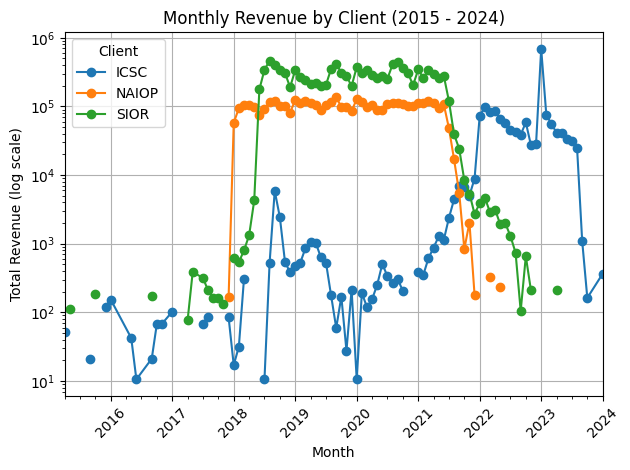

In [436]:
# Assuming 'df' is your DataFrame with the necessary columns

# Filtering data by date and grouping by month and client
df_filtered = df[df['EffectiveDate'].dt.year >= 2015]
df_filtered['Month'] = df_filtered['EffectiveDate'].dt.to_period('M')
revenue_by_month_filtered = df_filtered.groupby(['Month', 'Client'])['Total'].sum().unstack()

# Plotting the data
plt.figure(figsize=(10, 6))
ax = revenue_by_month_filtered.plot(kind='line', marker='o', linestyle='-')
ax.set_yscale('log')  # Set the y-axis to a logarithmic scale

# Setting plot titles and labels
plt.title('Monthly Revenue by Client (2015 - 2024)')
plt.xlabel('Month')
plt.ylabel('Total Revenue (log scale)')
plt.grid(True)
plt.legend(title='Client')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/ss/yqcdmh2s71390cvwl12h39300000gn/T/ipykernel_65718/958393637.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['EffectiveDate'].dt.to_period('M')


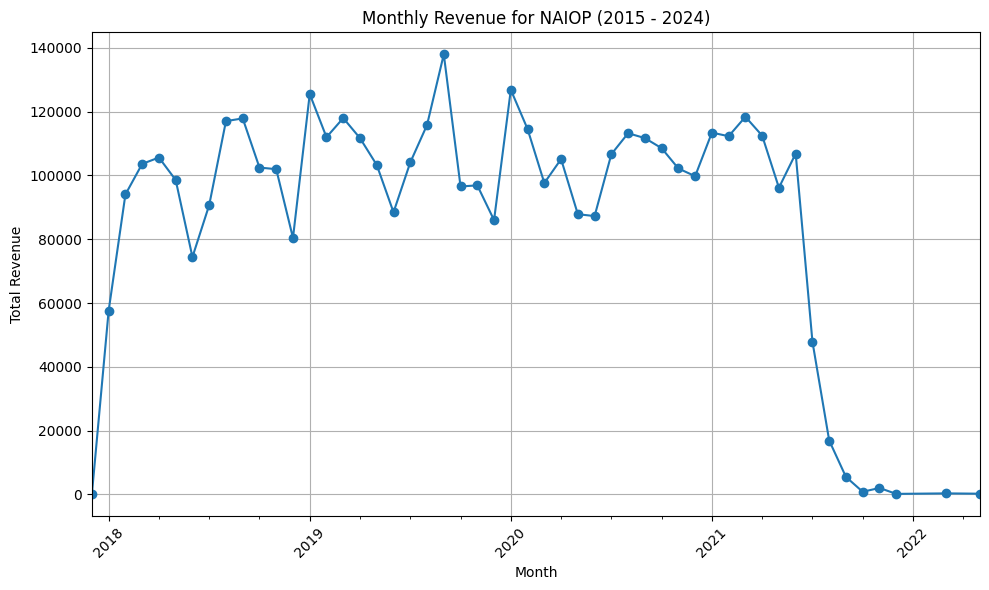

In [437]:
# Assuming 'df' is your DataFrame with the necessary columns

# Filtering data by client and date
df_filtered = df[(df['Client'] == 'NAIOP') & (df['EffectiveDate'].dt.year >= 2015)]
df_filtered['Month'] = df_filtered['EffectiveDate'].dt.to_period('M')

# Grouping data by month
revenue_by_month_naiop = df_filtered.groupby(['Month'])['Total'].sum()

# Plotting the data
plt.figure(figsize=(10, 6))
revenue_by_month_naiop.plot(kind='line', marker='o', linestyle='-')

# Setting plot titles and labels
plt.title('Monthly Revenue for NAIOP (2015 - 2024)')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/ss/yqcdmh2s71390cvwl12h39300000gn/T/ipykernel_65718/612211600.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['EffectiveDate'] = pd.to_datetime(client_data['EffectiveDate'])


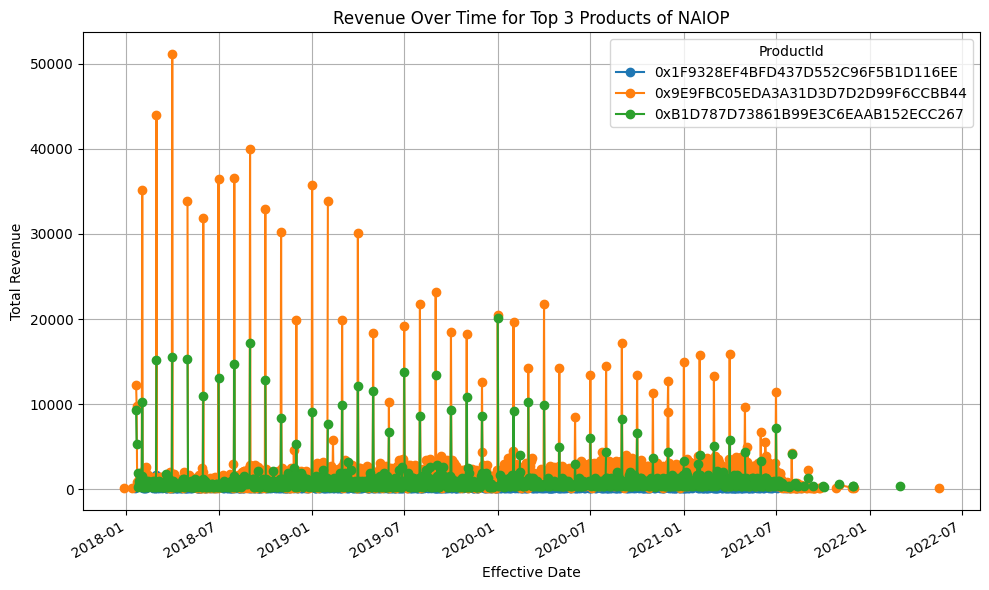

In [438]:
# Set your client of interest
client_of_interest = 'NAIOP'

client_data = df[df['Client'] == client_of_interest]
client_data['EffectiveDate'] = pd.to_datetime(client_data['EffectiveDate'])

top_products = client_data.groupby('ProductId')['Total'].sum().nlargest(3).index
top_product_data = client_data[client_data['ProductId'].isin(top_products)]
product_revenue_over_time = top_product_data.groupby(['EffectiveDate', 'ProductId']).agg({'Total': 'sum'}).unstack('ProductId')
product_revenue_over_time.columns = product_revenue_over_time.columns.droplevel()  # Drop multi-level column

# Plotting the time series data for the top 3 products
plt.figure(figsize=(10, 6))  # Set the figure size as needed
product_revenue_over_time.plot(kind='line', marker='o', ax=plt.gca())
plt.title(f'Revenue Over Time for Top 3 Products of {client_of_interest}')
plt.xlabel('Effective Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.legend(title='ProductId')
plt.tight_layout()
plt.show()

/var/folders/ss/yqcdmh2s71390cvwl12h39300000gn/T/ipykernel_65718/990851789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['EffectiveDate'] = pd.to_datetime(client_data['EffectiveDate'])


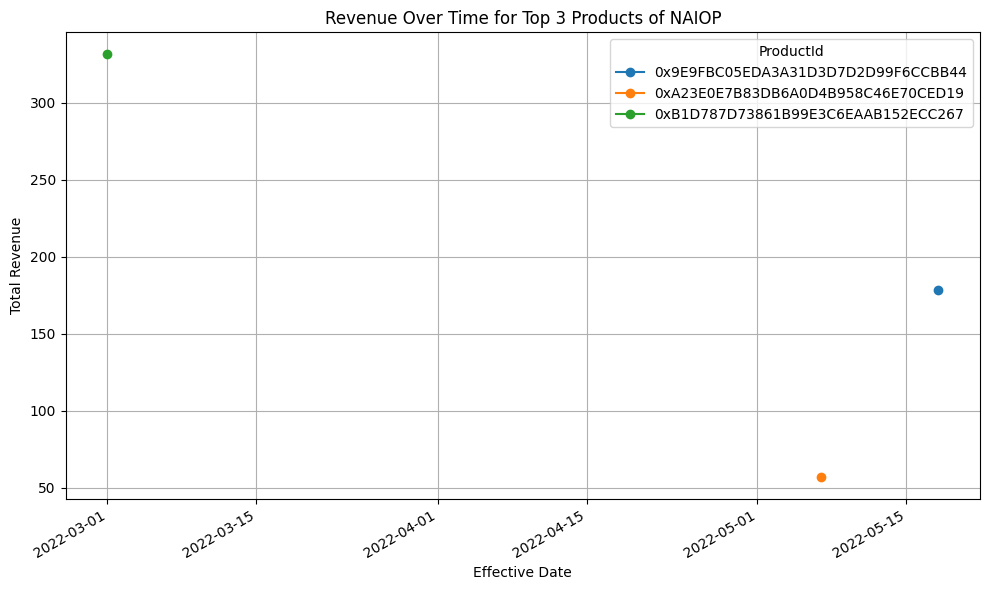

In [439]:
# Set your client of interest
client_of_interest = 'NAIOP'

client_data = df[(df['Client'] == client_of_interest) & (df['EffectiveDate'] >= '2022-01-01')]
client_data['EffectiveDate'] = pd.to_datetime(client_data['EffectiveDate'])

top_products = client_data.groupby('ProductId')['Total'].sum().nlargest(3).index
top_product_data = client_data[client_data['ProductId'].isin(top_products)]
product_revenue_over_time = top_product_data.groupby(['EffectiveDate', 'ProductId']).agg({'Total': 'sum'}).unstack('ProductId')
product_revenue_over_time.columns = product_revenue_over_time.columns.droplevel()

# Plotting the time series data for the top 3 products
plt.figure(figsize=(10, 6))  # Set the figure size as needed
product_revenue_over_time.plot(kind='line', marker='o', ax=plt.gca())
plt.title(f'Revenue Over Time for Top 3 Products of {client_of_interest}')
plt.xlabel('Effective Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.legend(title='ProductId')
plt.tight_layout()
plt.show()

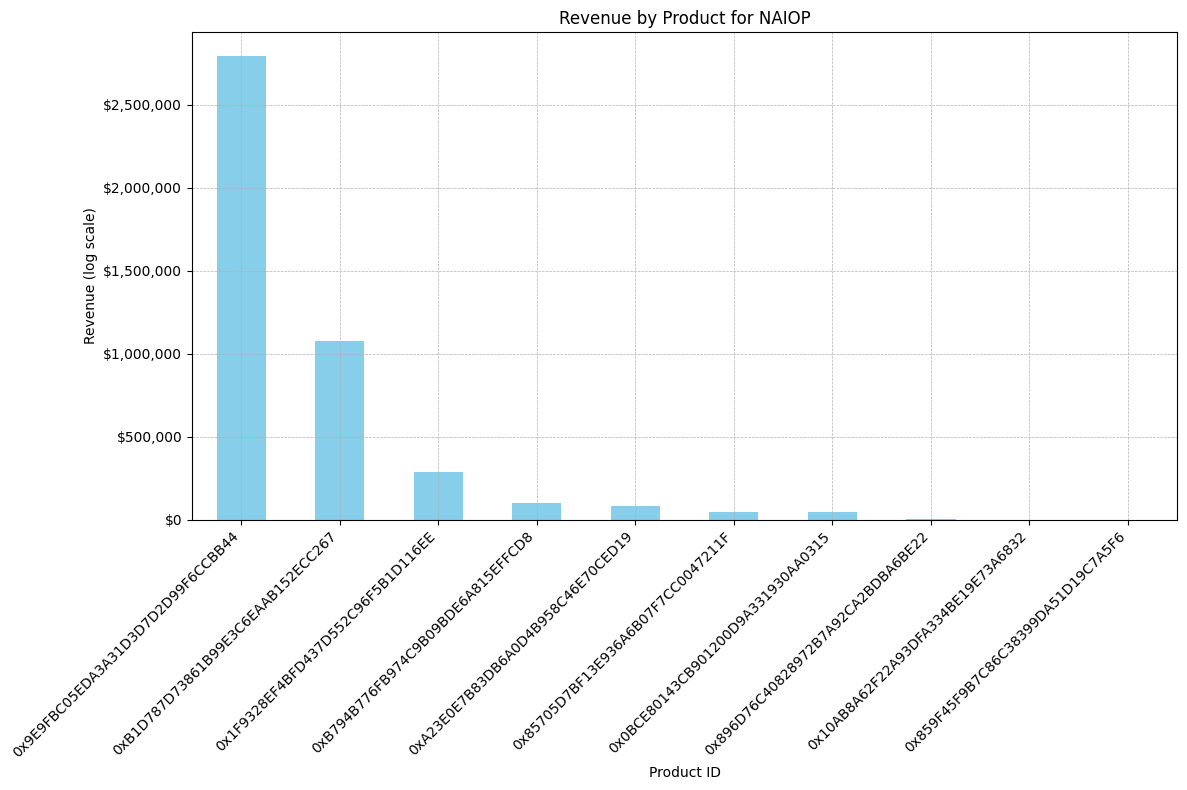

In [447]:
# Simulating the data for NAIOP
data = {
    'ProductId': [
        "0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44", 
        "0xB1D787D73861B99E3C6EAAB152ECC267", 
        "0x1F9328EF4BFD437D552C96F5B1D116EE", 
        "0xB794B776FB974C9B09BDE6A815EFFCD8", 
        "0xA23E0E7B83DB6A0D4B958C46E70CED19", 
        "0x85705D7BF13E936A6B07F7CC0047211F", 
        "0x0BCE80143CB901200D9A331930AA0315", 
        "0x896D76C40828972B7A92CA2BDBA6BE22", 
        "0x10AB8A62F22A93DFA334BE19E73A6832", 
        "0x859F45F9B7C86C38399DA51D19C7A5F6"
    ],
    'Total': [
        2.797043e+06, 1.073884e+06, 2.846097e+05, 
        9.956115e+04, 8.465310e+04, 4.799736e+04, 
        4.367439e+04, 3.118500e+03, 3.693600e+02, 
        2.916000e+01
    ]
}
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(12, 8))
ax = df.set_index('ProductId')['Total'].plot(kind='bar', logy=False, color='skyblue')

# Setting the axis labels and title
plt.title('Revenue by Product for NAIOP')
plt.xlabel('Product ID')
plt.ylabel('Revenue (log scale)')

# Setting y-axis formatter for log scale
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [442]:
# Filter the data for NAIOP and for the desired date range
df_naiop = df_mem[(df_mem['Client'] == 'NAIOP') &
                  (df_mem['EffectiveDate'].dt.year >= 2018) &
                  (df_mem['EffectiveDate'] < datetime(2021, 7, 1))]

df_naiop.head()

,ContactId,ClientId,Client,ProductId,ProductType,EffectiveDate,ExpireDate,Total
133044,Member 54164,0x69CB4E2FB587F20F7AF21D60E989ADAB,NAIOP,0x859F45F9B7C86C38399DA51D19C7A5F6,Membership,2020-09-01,2021-05-05,9.72
133045,Member 54164,0x69CB4E2FB587F20F7AF21D60E989ADAB,NAIOP,0x859F45F9B7C86C38399DA51D19C7A5F6,Membership,2020-09-01,2021-08-31,9.72
133059,Member 54166,0x69CB4E2FB587F20F7AF21D60E989ADAB,NAIOP,0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44,Membership,2021-06-28,2022-06-27,178.20
133062,Member 54167,0x69CB4E2FB587F20F7AF21D60E989ADAB,NAIOP,0x0BCE80143CB901200D9A331930AA0315,Membership,2021-06-29,2022-06-28,58.32
133063,Member 54168,0x69CB4E2FB587F20F7AF21D60E989ADAB,NAIOP,0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44,Membership,2021-06-29,2022-06-28,178.20


In [443]:
# Filter data for NAIOP
naiop_data = df_mem[df_mem['Client'] == 'NAIOP']
# Aggregate revenue by product
product_revenue = naiop_data.groupby('ProductId')['Total'].sum().reset_index()
# Sort products by total revenue in descending order
product_revenue_sorted = product_revenue.sort_values(by='Total', ascending=False)
# Get the top 5 products
top_3_revenue = product_revenue_sorted.head(3)['Total']
# Get the revenue for the rest of the products
rest_revenue = product_revenue_sorted.tail(len(product_revenue_sorted) - 3)['Total']
print("COUNT: ", rest_revenue.count())
# Perform the two-sample t-test between the top 5 products and the rest
t_stat, p_value = ttest_ind(top_3_revenue, rest_revenue)  # Use equal_var=False if you assume variances are unequal
print(f"T-statistic: {t_stat}, P-value: {p_value}")
# Interpretation based on the p-value
alpha = 0.05
if p_value < alpha:
    print("The average revenue from the top 3 products is significantly different from the rest.")
else:
    print("There is no significant difference in average revenue between the top 3 products and the rest.")


# 11  NAIOP  0x9E9FBC05EDA3A31D3D7D2D99F6CCBB44  2.797043e+06
# 13  NAIOP  0xB1D787D73861B99E3C6EAAB152ECC267  1.073884e+06
# 7   NAIOP  0x1F9328EF4BFD437D552C96F5B1D116EE  2.846097e+05
# 14  NAIOP  0xB794B776FB974C9B09BDE6A815EFFCD8  9.956115e+04
# 12  NAIOP  0xA23E0E7B83DB6A0D4B958C46E70CED19  8.465310e+04
# 8   NAIOP  0x85705D7BF13E936A6B07F7CC0047211F  4.799736e+04
# 5   NAIOP  0x0BCE80143CB901200D9A331930AA0315  4.367439e+04
# 10  NAIOP  0x896D76C40828972B7A92CA2BDBA6BE22  3.118500e+03
# 6   NAIOP  0x10AB8A62F22A93DFA334BE19E73A6832  3.693600e+02
# 9   NAIOP  0x859F45F9B7C86C38399DA51D19C7A5F6  2.916000e+01


COUNT:  7
T-statistic: 3.0299752316700785, P-value: 0.016310030930518717
The average revenue from the top 3 products is significantly different from the rest.


In [444]:
# Filter data for ICSC
naiop_data = df_mem[df_mem['Client'] == 'ICSC']
# Aggregate revenue by product
product_revenue = naiop_data.groupby('ProductId')['Total'].sum().reset_index()
# Sort products by total revenue in descending order
product_revenue_sorted = product_revenue.sort_values(by='Total', ascending=False)
# Get the top 5 products
top_3_revenue = product_revenue_sorted.head(3)['Total']
# Get the revenue for the rest of the products
rest_revenue = product_revenue_sorted.tail(len(product_revenue_sorted) - 3)['Total']
print("COUNT: ", rest_revenue.count())
# Perform the two-sample t-test between the top 5 products and the rest
t_stat, p_value = ttest_ind(top_3_revenue, rest_revenue)  # Use equal_var=False if you assume variances are unequal
print(f"T-statistic: {t_stat}, P-value: {p_value}")
# Interpretation based on the p-value
alpha = 0.05
if p_value < alpha:
    print("The average revenue from the top 3 products is significantly different from the rest.")
else:
    print("There is no significant difference in average revenue between the top 3 products and the rest.")

# 3    ICSC  0x9E8B160226C9FE22A910C782CE5076E2  1.122092e+06
# 2    ICSC  0x8C19A547F4F2D76D4F47B8EFFB73F4F7  1.972465e+05
# 1    ICSC  0x54F95A5E234DD10A3244A98632BA45CB  1.760362e+05
# 0    ICSC  0x5158A250E30F1FB4415D86DED2C8E0C5  1.528739e+05
# 4    ICSC  0xF5C0A1C9384C2E25E79BA1ABF5D9A037  1.076415e+05

COUNT:  2
T-statistic: 0.9136848937676764, P-value: 0.42825418853886055
There is no significant difference in average revenue between the top 3 products and the rest.


In [445]:
# Filter data for SIOR
naiop_data = df_mem[df_mem['Client'] == 'SIOR']
# Aggregate revenue by product
product_revenue = naiop_data.groupby('ProductId')['Total'].sum().reset_index()
# Sort products by total revenue in descending order
product_revenue_sorted = product_revenue.sort_values(by='Total', ascending=False)
# Get the top 5 products
top_3_revenue = product_revenue_sorted.head(19)['Total']
# Get the revenue for the rest of the products
rest_revenue = product_revenue_sorted.tail(len(product_revenue_sorted) - 19)['Total']
print("COUNT: ", rest_revenue.count())
# Perform the two-sample t-test between the top 5 products and the rest
t_stat, p_value = ttest_ind(top_3_revenue, rest_revenue)  # Use equal_var=False if you assume variances are unequal
print(f"T-statistic: {t_stat}, P-value: {p_value}")
# Interpretation based on the p-value
alpha = 0.05
if p_value < alpha:
    print("The average revenue from the top 19 products is significantly different from the rest.")
else:
    print("There is no significant difference in average revenue between the top 19 products and the rest.")

# 44   SIOR  0x9E8B160226C9FE22A910C782CE5076E2  6.711268e+06
# 63   SIOR  0xF5C0A1C9384C2E25E79BA1ABF5D9A037  1.954636e+06
# 31   SIOR  0x83328A9B5BCBD66B31C8B882E78C7B0F  1.046778e+06
# 48   SIOR  0xBC0C8546EF1FC064C277B3CEECF1B68E  5.484348e+05
# 54   SIOR  0xD109AC74DF282488EFD1DD7621A847D2  1.038487e+05
# 47   SIOR  0xBB166FEFF34B74FEF81127259160C93A  8.203861e+04
# 32   SIOR  0x847D827DAC4CED82AE7907495A7399C9  8.146899e+04
# 20   SIOR  0x2C5EAF03FB31E4EB10D8CB3786C0DF00  6.009390e+04
# 38   SIOR  0x941CFE1F75F9BF7E4577700E2C16D7CA  5.525010e+04
# 22   SIOR  0x3A6A1693FA5A8298B28EF588CFEF866B  4.496553e+04

COUNT:  31
T-statistic: 2.039472342622915, P-value: 0.04692819261282372
The average revenue from the top 19 products is significantly different from the rest.


/var/folders/ss/yqcdmh2s71390cvwl12h39300000gn/T/ipykernel_65718/816328068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['EffectiveDate'].dt.to_period('M')


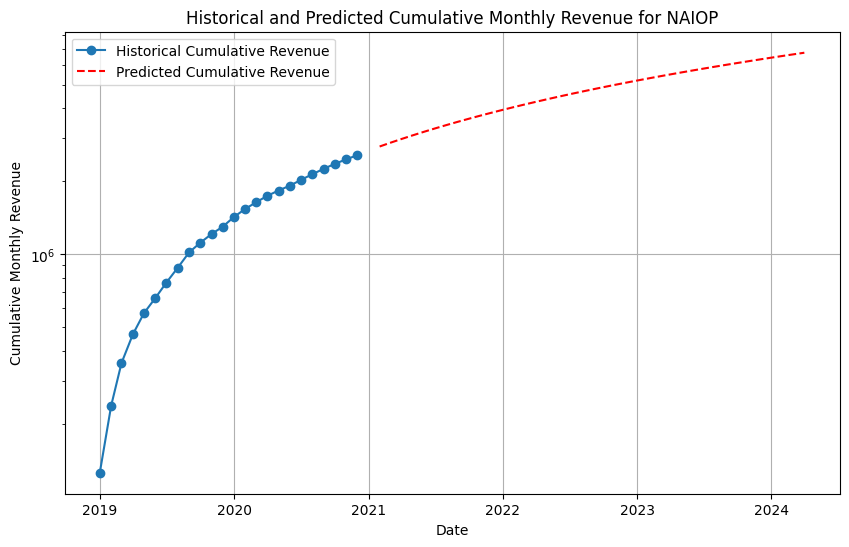

In [446]:
# Assuming 'df_mem' is your DataFrame with the necessary columns for membership data

# Filtering data by client and date
df_filtered = df_mem[(df_mem['Client'] == 'NAIOP') & (df_mem['EffectiveDate'].dt.year >= 2019)]
df_filtered['Month'] = df_filtered['EffectiveDate'].dt.to_period('M')

# Grouping data by month to calculate monthly revenue
revenue_by_month_naiop = df_filtered.groupby(['Month'])['Total'].sum().reset_index()
revenue_by_month_naiop['Month'] = revenue_by_month_naiop['Month'].dt.to_timestamp()

# Calculating cumulative revenue
revenue_by_month_naiop['Cumulative Total'] = revenue_by_month_naiop['Total'].cumsum()

# Fit the linear regression model to data up to mid-2021 using cumulative revenue
training_data = revenue_by_month_naiop[revenue_by_month_naiop['Month'] < pd.Timestamp('2021-01-01')]
X_train = np.array([d.toordinal() for d in training_data['Month']]).reshape(-1, 1)
y_train = training_data['Cumulative Total'].values

model = LinearRegression()
model.fit(X_train, y_train)

# Generate dates from mid-2021 to the present for predictions
predict_dates = pd.date_range(start='2021-01-01', end=pd.to_datetime("today"), freq='M')
predict_dates_ordinal = np.array([d.toordinal() for d in predict_dates]).reshape(-1, 1)

# Predict the cumulative monthly revenue
predicted_sales = model.predict(predict_dates_ordinal)

# Plotting historical cumulative data up to mid-2021
plt.figure(figsize=(10, 6))
plt.plot(training_data['Month'], training_data['Cumulative Total'], label='Historical Cumulative Revenue', marker='o')

# Plotting predicted cumulative revenue from mid-2021 to present
plt.plot(predict_dates, predicted_sales, label='Predicted Cumulative Revenue', linestyle='--', color='red')

# Set the title and labels
plt.title('Historical and Predicted Cumulative Monthly Revenue for NAIOP')
plt.xlabel('Date')
plt.ylabel('Cumulative Monthly Revenue')
plt.legend()
plt.grid(True)

plt.gca().set_yscale('log')

# Display the plot
plt.show()
